# Network models

One thing that may be bothering you about SIR is the idea of a population where all the possible interactions between individuals take place. You don't meet everyonme in your city, town, or village like that on a regular basis: that isn't how societies work.

Admittedly you get this sort of "complete mixing" in *some* scenarios. A school for young children (or, even better, a toddler's nursery) perhaps works like this as the children go out to play together and everyone mixes with everyone else. And this is why diseases spread so rapidly through nurseries: one sick child will infect all the others.

```{margin}
In chickenpox the infected individual &ndash; almost always a
child &ndash; is latent for 7–10 days after exposure, but only
infectious for about 24 hours before the symptoms (an itchy rash)
appear.
```

This phenomenon can be used constructively. When I was a child it was commonplace for parents to hold "chickenpox parties" and bring all the neighbouring children together to play so they could be exposed &ndash; and then subsequently be immune from further infection, since chickenpox confers very strong immunity.

But in other cases the assumption of complete mixing is going to break down. And since we know that even a small change in infectivity can have a dramatic effect on the progress of an epidemic, can we change SIR to accommodate the social realities in which there are substantially fewer connections between individuals that we might expect?

## Networks

There are a couple of ways of ansering this question, but the one we'll turn to here uses networks.

```{margin}
The term **graph** is often used as a synonym for network.
```

A **network** is simply a collection of **nodes** connected by **edges**. A road map is a good example of a network: the nodes are the road junctions, while the edges (which connect the junctions together) are the segments of roads. This is the reason we sometimes refer to the *road network*: it's a collection of (bits of) road that meet at various points.

Another good example of a network &ndash; and closer to our current application &ndash; is a **social network**. In a social network the nodes are people and the edges are "social links" or "social contacts" between them. While we usually think of social networks as being online, like Facebook or Twitter, they idea works in the real world too: when you meet your family, go shopping, go to work, or indulge in any of the activities of daily life you add edges to your social network between yourself and the people you meet. Typically the number of people you'll have social contact with will be considerably less that the entire population.

Do the same thing for everyone in the population, and you have a social network for that population. The nodes are the individuals; the edges are the potentially infection-carrying social contacts.


(sec:network-complete)=
## Complete networks

Suppose that, on your travels, you *did* actually happen to come into contact with everyone in the population, so that your social network had edges connecting you to everyone else. And suppose that everyone else did the same, so that everyone was connected to everyone. This is still a social network &ndash; a very dense one to be sure, perhaps like what happens on a nightclub dance floor. It also matches the assumptions we made earlier about complete mixing. So if we  ran a simulation of disease spreading over this network, we'd presumably expect to see the same results as we did before.

Wouldn't we?

In [1]:
import numpy

In [2]:
def make_sir(beta, alpha):
    # turn the equations into update functions
    def dS(S, I, R):
        return -beta * S * I
    def dI(S, I, R):
        return beta * S * I - alpha * I
    def dR(S, I, R):
        return alpha * I
    
    # return the three functions
    return (dS, dI, dR)

In [3]:
def epidemic_sir(T, N, pInfected, pInfect, pRemove):
    # create the equations for these parameters
    (dS, dI, dR) = make_sir(pInfect, pRemove)
    
    # initial conditions
    sss = [ N * (1.0 - pInfected) ]   # everyone is initially susceptible...
    iss = [ N * pInfected ]           # ...except for this fraction...
    rss = [ 0 ]                       # ...and no-one starts off removed

    # push the initial conditions through the differential equations
    for t in range(1, T):
        ds = dS(sss[-1], iss[-1], rss[-1])
        di = dI(sss[-1], iss[-1], rss[-1])
        dr = dR(sss[-1], iss[-1], rss[-1])
        sss.append(sss[-1] + ds)
        iss.append(iss[-1] + di)
        rss.append(rss[-1] + dr)
        
    # return the time series
    return (list(range(0, T)), sss, iss, rss)

In [4]:
N = 2000
T = 5000
pInfected = 0.01
pRemove = 0.001

In the previous chapter we "pushed" an initial population of nodes through the equations. For a network we can do something slightly different. Each node represents an individual, so we have a colleciton of people whose evolution we can track through the SIR disease (rather than simply counting them). That will be useful later. But clearly there's more "book-keeping" to do in keeping track of everyone. It's harder, from a programming perspective, to model the disease on a network &ndash; but in doing so we gain a lot of flexibility, as we'll see later.

For the moment, we need to set up a computational simulation of the people and their connections. Fortunately there we have software than can help us do this.

In [5]:
import networkx
import epydemic

Since we're interested in the progress of an epidemic, we'll create an SIR process and then add some monitoring to get the same time series that we got for the continuous case. 

In [6]:
class MonitoredSIR(epydemic.SIR, epydemic.Monitor):
 
    def __init__(self):
        super(MonitoredSIR, self).__init__()
        
    def build(self, params):
        '''Build the observation process.
        
        :param params: the experimental parameters'''
        super(MonitoredSIR, self).build(params)

        # also monitor other compartments
        self.trackNodesInCompartment(epydemic.SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(epydemic.SIR.REMOVED)

We can now write a function to perform the simulation for given parameters of `pInfected`, `pInfect`, and `pRemove`. For completeness we'll also pass the function a network over which to run the simulation. The function sets up the simulation using ``epydemic``, runs it, and extracts the results.

In [7]:
def network_sir(T, g, pInfected, pInfect, pRemove):
    # create the simulator
    m = MonitoredSIR()
    m.setMaximumTime(T)
    e = epydemic.SynchronousDynamics(m, g)

    # set the simulation parameters
    param = dict()
    param[epydemic.SIR.P_INFECTED] = pInfected
    param[epydemic.SIR.P_INFECT] = pInfect
    param[epydemic.SIR.P_REMOVE] = pRemove
    param[epydemic.Monitor.DELTA] = T / 50          # take 50 samples
    
    # run the simulation
    rc = e.set(param).run()
    
    # extract the time series
    results = e.experimentalResults()[MonitoredSIR.TIMESERIES]
    ts = results[MonitoredSIR.OBSERVATIONS]
    sss = results[epydemic.SIR.SUSCEPTIBLE]
    iss = results[epydemic.SIR.INFECTED]
    rss = results[epydemic.SIR.REMOVED]

    # return the time series
    return(ts, sss, iss, rss)

To test our hypothesis, we need a complete "social network" to operate over. Such networks are often called *complete graphs*, with every node connected by an edge to every other.

In [8]:
g = networkx.complete_graph(N)

Finally we can run the equations *and* the network simulation and plot them together. If they generate the same results, we'd expect the two datasets to agree with each other.

In [9]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_formats = {'svg', 'png'}
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')

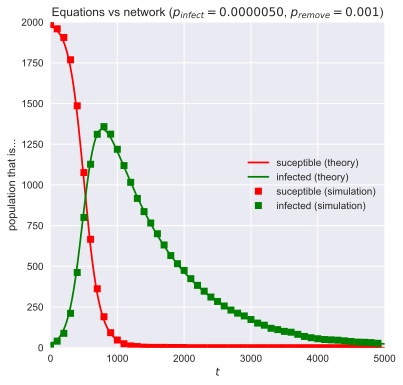

In [23]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

pInfect = 0.000005      # chosen simply for illustration

# run the epidemic equations
ts, sss, iss, rss) = epidemic_sir(T, N, pInfected, pInfect, pRemove)
ax.plot(ts, sss, 'r-', label='suceptible (theory)')
ax.plot(ts, iss, 'g-', label='infected (theory)')
#ax.plot(ts, rss, 'k-', label='removed (theory)')

# run the corresponding simulation
(sim_ts, sim_sss, sim_iss, sim_rss) = network_sir(T, g, pInfected, pInfect, pRemove)
ax.plot(sim_ts, sim_sss, 'rs', label='suceptible (simulation)')
ax.plot(sim_ts, sim_iss, 'gs', label='infected (simulation)')
#ax.plot(sim_ts, sim_rss, 'kx', label='removed (simulation)')

# fine-tune the figure
plt.title('Equations vs network ($p_{\\mathit{infect}} = ' + '{b:.7f}$, '.format(b=pInfect) + '$p_{remove} = ' + '{a}$)'.format(a=pRemove))
ax.set_xlabel('$t$')
ax.set_xlim([0, T])
ax.set_ylabel('population that is...')
ax.set_ylim([0, N])
ax.legend(loc='center right')
plt.savefig('network-same-beta-alpha.svg')
plt.show()

```{margin}
Not *exactly* over, for reasons we'll come to later.
```

And so they do: the crosses of the simulation lie over the top of the solid lines of the SIR equations.

## The story so far

To recap, we defined SIR as a process and explored what happened in a scenario of complete mixing. We then reproduced these results in a different framework, with the same process running over a network, also with complete mixing. But clearly complete mixing isn't a good model of a social network: you don't meet everyone all the time, and therefore don't get exposed to all possible infected people.

Real social networks are very different: more "clumpy", more uneven, some people with more contacts than others. Everyone experiences this, and one would think that the differences (in the social contact structure) will make a difference to the epidemic (in the way it spreads). This is indeed the case, and we can explore it.

The simulation we ran above has two parts: the SIR process, and the network we ran it over &ndash; which in this case was a complete graph. We can of course change the network, and as we do we can explore how the disease behaves for different kinds of network. In the spirit of good science, we'll keep the disease the same, and only change the context in which it occurs, so that any changes we observe will be due to change in the network.

## Questions for discussion

- We've now done two simulations of the same disease model: with equations, and with simulation. Which do you trust the results of more? Why?
- (For programmers.) How would you go about building a simulator for SIR? 